In [1]:
%load_ext autoreload
%autoreload 2
#pip install -U python-dotenv


In [2]:
%run ../nb_config.py  # place a .py to set root_path in order to be able to import from src folder

running notebook configuration


In [3]:
path=os.environ.get('LOCAL_PATH')

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn.metrics import mean_squared_error, accuracy_score

from src.data_api import sources
from src import utils

from src import data_preparation as dataprep

import pandas as pd
import numpy as np

import random as rd

import seaborn as sns
from sklearn.ensemble import RandomForestRegressor


state = rd.getstate()
rd.setstate(state)
 

In [5]:
conf = utils.get_conf()

# Load Data

In [6]:
wiki_prices=pd.read_pickle(path+"data/processed/wiki_prices.pkl")
test=pd.read_pickle(path+"data/processed/test.pkl")

# Testing

In [7]:
#lets create columns to compare
# doing random movements: 
#1-> long, 0 stay, -1 short
test["rd_movement"]= np.array(pd.Series(rd.choices([1,0,-1], k=test.shape[0])))

In [8]:
# always buying/always selling

test["all_long"]= 1
test["all_short"]= -1

#always doing what the sign tell
tau=5
test["sign"]=  np.sign(test["x_diff5d"]) 
 

In [9]:
sum(np.sign(test["x_returns5d"])) ==  sum(np.sign(test["x_diff5d"]))

True

In [10]:
print("max possible : " ,(np.abs(test["diff_target"]).sum()))
print("total rd : " ,(test["diff_target"]*test["rd_movement"]).sum())
print("total all_long : " ,(test["diff_target"]*test["all_long"]).sum())
print("total all_short : " ,(test["diff_target"]*test["all_short"]).sum())
print("total current 5 sign : " ,(test["diff_target"]*test["sign"]).sum())
#print("total current ln5 sign : " ,(wiki_prices["diff"]*wiki_prices["sign"]).sum())

max possible :  52567.8498773744
total rd :  598.5663028303987
total all_long :  -3328.224737499998
total all_short :  3328.224737499998
total current 5 sign :  2243.4505253458


(array([14860.,     0.,     0.,     0.,     0.,   136.,     0.,     0.,
            0., 14504.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

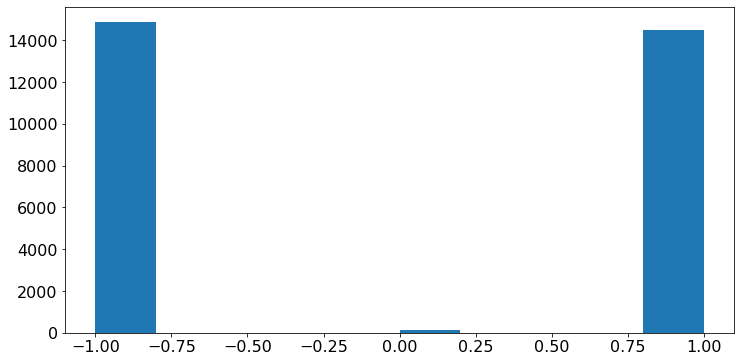

In [11]:
# distribución sign
plt.hist(test["sign"].astype("category"))


## USING LOG RETURNS

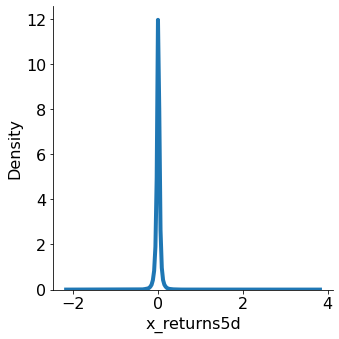

In [12]:
sns.displot(wiki_prices, x=wiki_prices["x_returns5d"], kind="kde")


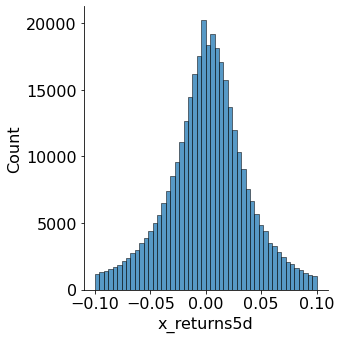

In [13]:
sns.displot(wiki_prices[(wiki_prices["x_returns5d"]>-0.1) & (wiki_prices["x_returns5d"]< 0.1)], x="x_returns5d" , bins=50 )


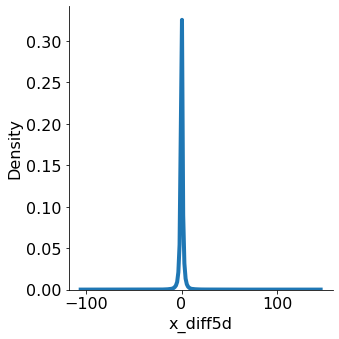

In [14]:
sns.displot(wiki_prices, x=wiki_prices["x_diff5d"], kind="kde")


In [15]:
wiki_prices.x_returns5d.describe()

count   377,008.0000
mean          0.0002
std           0.0645
min          -2.1580
25%          -0.0216
50%           0.0020
75%           0.0242
max           3.8063
Name: x_returns5d, dtype: float64

In [16]:
#lets make 0.01 intervals
thresholds=np.arange( 0, 0.1, 0.001).tolist()
total_gain=[]

In [17]:
for th in thresholds:
    movement =   wiki_prices["x_returns5d"].apply(lambda x: np.sign(x) if np.abs(x)>th else 0)
    total_gain.append((wiki_prices["diff_target"]*movement ).sum())

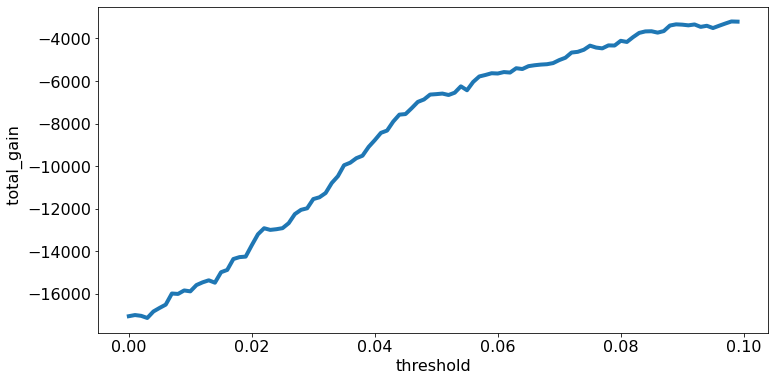

In [18]:
plt.plot(thresholds,total_gain)
plt.ylabel('  total_gain')
plt.xlabel('threshold')

plt.show()

always loosing money 

## Training a random Forest

In [19]:
train_features=wiki_prices[["x_returns5d","x_diff5d","x_returns1y","x_diff1y","x_returns_1y_sdmean","x_returns_1y_zscr","x_returns_1y_tsmooth"]]
train_target=wiki_prices["target"]

test_features=test[["x_returns5d","x_diff5d","x_returns1y","x_diff1y","x_returns_1y_sdmean","x_returns_1y_zscr","x_returns_1y_tsmooth"]]
test_target=test["target"]

In [20]:
# Import the model we are using
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(  random_state = 42)
# Train the model on training data
rf.fit(train_features, train_target) 

RandomForestRegressor(random_state=42)

In [21]:
print("RF train accuracy: %0.3f" % rf.score(train_features, train_target))
print("RF test accuracy: %0.3f" % rf.score(test_features, test_target))
#provides the coefficient of determination (R**2) 

RF train accuracy: 0.877
RF test accuracy: -0.102


Text(0.5, 0, 'Random Forest Feature Importance')

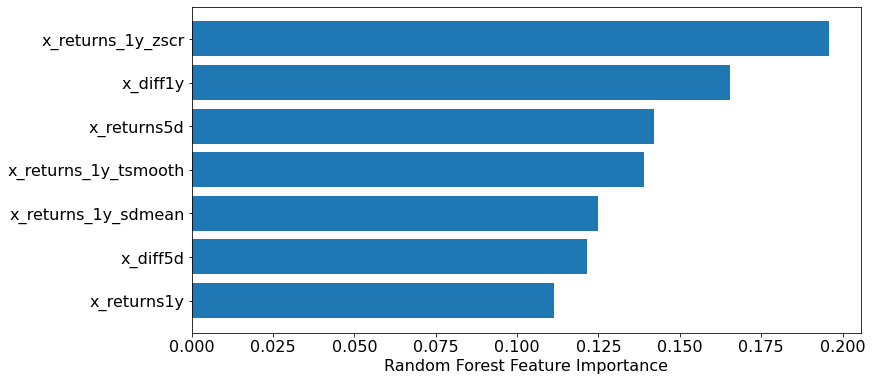

In [22]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(train_features.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")